In [ ]:
!pip install -qU diffusers accelerate transformers huggingface_hub diffusers[training]

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Train a diffusion model

Unconditional image generation is a popular application of diffusion models that generates images that look like those in the dataset used for training. The best results are obtained from finetuning a pretrained model on a specific dataset.

In this session, we will train a `UNet2DModel` from scratch on a subset of the Smithsonian Butterfiles dataset to generate our own butterfiles.

## Training configuration

We need to create a `TrainingConfig` class containing the training hyperparameters:

In [4]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128 # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16' # 'fp16' for automatic mixed precision
    output_dir = 'ddpm-butterflies-128'

    push_to_hub = False
    hub_model_id = 'lblogan14/butterflies-128'
    hub_private_repo = None
    overwrite_output_dir = True # overwrite the old model when re-running the notebook
    seed = 111


config = TrainingConfig()

## Load the dataset

In [ ]:
from datasets import load_dataset

config.dataset_name = 'huggan/smithsonian_butterflies_subset'
dataset = load_dataset(
    config.dataset_name,
    split='train',
)

HF Datasets uses the Image feature to automatically decode the image data and load it as a `PIL.Image`:

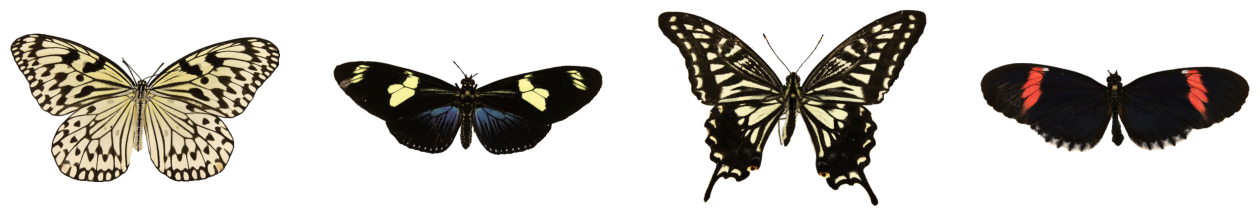

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]['image']):
    axes[i].imshow(image)
    axes[i].set_axis_off()
fig.show()

The images are all in different sizes, so we have to preprocess them:
* `Resize` changes the image size to the one defined in `config.image_size`.
* `RandomHorizontalFlip` augments the dataset by randomly mirroring the images.
* `Normalize` rescales the pixel values into a [-1, 1] range, which is what the model expects.

In [7]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ]
)

We can use HF Datasets' `set_transform` method to apply the `preprocess` function on the fly during training:

In [8]:
def transform(examples):
    images = [
        preprocess(image.convert('RGB'))
        for image in examples['image']
    ]
    return {'images': images}

dataset.set_transform(transform)

We can visualize the image again after the preprocessing:

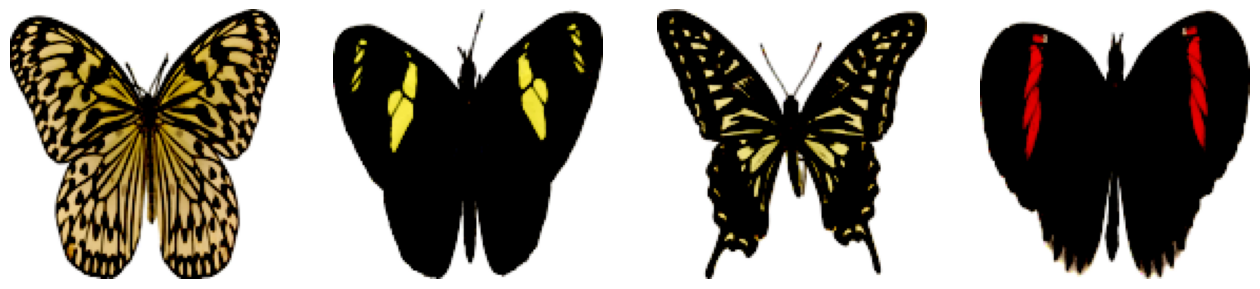

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]['images']):
    axes[i].imshow(image.permute(1, 2, 0))
    axes[i].set_axis_off()
fig.show()

Now we can wrap the dataset in a `DataLoader` for training.

In [10]:
import torch

train_dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config.train_batch_size,
    shuffle=True,
)

## Create a UNet2DModel

In [11]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size, # the target image resolution
    in_channels=3, # the number of input channels
    out_channels=3, # the number of output channels
    layers_per_block=3, # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512), # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D", # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D", # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D", # a regular ResNet upsampling block
        "AttnUpBlock2D", # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

We can check if the sample image shape matches the model output shape:

In [12]:
sample_image = dataset[0]['images'].unsqueeze(0)
print('Input shape:', sample_image.shape)

print('Output shape:', model(sample_image, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 128])
Output shape: torch.Size([1, 3, 128, 128])


## Create a scheduler

The scheduler behaves differently depending on whether we use the model for training or inference.

* During inference, the scheduler generates image from the noise.
* During training, the scheduler takes a model output - or a sample - from a specific point in the diffusion process and applies noise to the image according to a *noise schedule* and an *update rule*.

For `DDPMScheduler`, we can use the `add_noise` method to add some random noise to the `sample_image` from before:

In [13]:
import torch
from PIL import Image
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])

noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

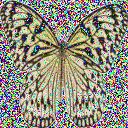

In [14]:
Image.fromarray(
    (
        (noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5
    ).type(torch.uint8).numpy()[0]
)

The training objective of the model is to predict the noise aded to the image.

The loss function at this step can be calculated by:

In [15]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)
loss

tensor(1.0844, grad_fn=<MseLossBackward0>)

## Train the model

First, we will need an optimizer and a learning rate scheduler

In [16]:
from diffusers.optimization import get_cosine_schedule_with_warmup

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

Then we will need a way to evaluate the model. For evaluation, we can use the `DDPMScheduler` to generate a batch of sample iamges and save it as a grid.

In [17]:
from diffusers import DDPMPipeline
from diffusers.utils import make_image_grid
import os


def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process)
    # The default pipeline output type is `List[PIL.Image]`

    images = pipeline(
        batch_size=config.eval_batch_size,
        # use a separate torch generator to avoid rewinding the random state of the main training loop
        generator=torch.Generator(device='cpu').manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, 'samples')
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

Now we can wrap all these components together in a training loop with HF Accelerate for easy TensorBoard logging, gradient accumulation, and mixed precision training.

In [18]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

In [19]:
def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with='tensorboard',
        project_dir=os.path.join(config.output_dir, 'logs'),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name,
                exist_ok=True,
            ).repo_id

        accelerator.init_trackers('train_example')

    # Prepare everything
    # There is no specific order to remember, we just need to unpack the
    # objects in the same order we gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler,
    )

    global_step = 0

    # Now we train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(
            total=len(train_dataloader),
            disable=not accelerator.is_local_main_process,
        )
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0] # batch size

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0,
                noise_scheduler.config.num_train_timesteps,
                (bs,),
                device=clean_images.device,
                dtype=torch.int64,
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # Forward diffusion process
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()


            progress_bar.update(1)
            logs = {
                'loss': loss.detach().item(),
                'lr': lr_scheduler.get_last_lr()[0],
                'step': global_step,
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1


        # After each epoch we optionally sample some demo images with evaluate()
        # and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(
                unet=accelerator.unwrap_model(model),
                scheduler=noise_scheduler,
            )

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

args = (
    config,
    model,
    noise_scheduler,
    optimizer,
    train_dataloader,
    lr_scheduler,
)

notebook_launcher(
    train_loop,
    args,
    num_processes=1,
)

Once training is complete, we can take a look at the final images

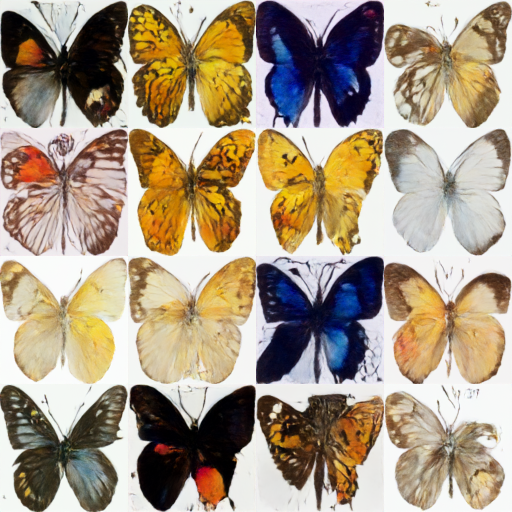

In [21]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])